### Utilisation de ResNet

In [2]:
# imports 
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
image_train_directory = './data/articles_train'
image_test_directory = './data/articles_test'

print(os.listdir(image_train_directory))
print(os.listdir(image_test_directory))

['W SLG', 'Watches', 'W RTW', 'W Bags', 'W Accessories', 'W Shoes']
['W SLG', 'Watches', 'W Bags', 'W Accessories', 'W Shoes']


## Normalisation des images pour le modèle

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# première lecture des données
dataset_train = datasets.ImageFolder(image_train_directory, data_transforms)
dataset_test = datasets.ImageFolder(image_test_directory, data_transforms)

print(len(dataset_train))
print(len(dataset_test))

2766
78


In [6]:
# some useful info
print("Classes train :", dataset_train.classes)
print("Classes test :", dataset_test.classes)

print("Mapping class to index :", dataset_train.class_to_idx)
print(dataset_train.samples[0])

Classes train : ['W Accessories', 'W Bags', 'W RTW', 'W SLG', 'W Shoes', 'Watches']
Classes test : ['W Accessories', 'W Bags', 'W SLG', 'W Shoes', 'Watches']
Mapping class to index : {'W Accessories': 0, 'W Bags': 1, 'W RTW': 2, 'W SLG': 3, 'W Shoes': 4, 'Watches': 5}
('./data/articles_train/W Accessories/01CDO370I001C810.jpeg', 0)


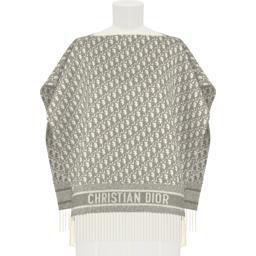

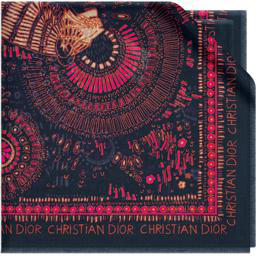

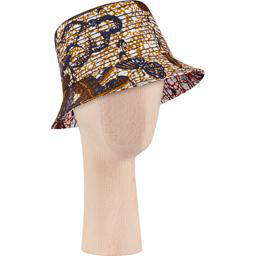

In [7]:
# viz
for ii in range(3) : 
    img_path, label = dataset_train.samples[ii]
    with Image.open(img_path) as img:    
        display(img)

## Split des données

In [8]:
# on split en train, val et test à partir de la liste complète
np.random.seed(42)

labels = [label for _, label in dataset_train.samples]

samples_train, samples_val = train_test_split(dataset_train.samples, test_size=0.20, stratify=labels) # train vs val, 15/75 = 0.2


print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
# print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 2212
Nombre d'images de val : 554


On définit un `DataLoader` pour chacun des sous-ensembles de données. 


In [9]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test

dataset_train = datasets.ImageFolder(image_train_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, 
                                           shuffle=True, num_workers=4)

dataset_val = datasets.ImageFolder(image_train_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_test_directory, data_transforms)

Vérification : toutes les classes doivent être représentées dans le jeu de données d'entrainement.

In [10]:
# détermination du nombre de classes (nb_classes=6)
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
# nb_classes = len(dataset_train.classes)
print("Apprentissage sur {} classes".format(nb_classes))


Apprentissage sur 6 classes


In [11]:
torch.manual_seed(42)

## Chargement d'un modèle pré-entrainé

In [12]:
# Récupérer un réseau pré-entraîné (resnet-18)
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1') 

Récupération du ResNet-18 pré-entraîné...


In [13]:
# architecture
print(my_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Quelle est la taille de sortie de l'extracteur de features ?

Il y en a 512

### 3. Transfert d'apprentissage

In [14]:
# on indique qu'il est inutile de calculer les gradients des paramètres du réseau
for param in my_net.parameters():
    param.requires_grad = False

In [15]:
# on remplace la dernière couche fully connected à 1000 sorties (classes d'ImageNet) par une fully connected à 6 sorties (nos classes).
# par défaut, les gradients des paramètres cette couche seront bien calculés
#  NB: par défaut, la couche réinitialisée a .requires_grad=True
my_net.fc = nn.Linear(in_features=512, out_features=6, bias=True)
# on pourrait aussi réinitaliser d'autres couches e.g. my_net.layer4[1].conv2


In [16]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
#device = torch.device("cpu") # forcer en CPU s'il y a des problèmes de mémoire GPU (+ être patient...)

In [17]:
my_net.to(device) # on utilise le GPU / CPU en fonction de ce qui est disponible

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

__Entrainement et évaluation__

On donne une fonction d'entrainement et une fonction d'évaluation (cf TPs précédents).

In [24]:
# on définit une fonction d'évaluation
def evaluate(model, dataset, criterion):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)


In [25]:
# fonction classique d'entraînement d'un modèle, voir TDs précédents
PRINT_LOSS = True
def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10):
    for epoch in range(n_epochs): # à chaque epochs
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train): # itère sur les minibatchs via le loader apprentissage
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # on passe les données sur CPU / GPU
            optimizer.zero_grad() # on réinitialise les gradients
            outputs = model(inputs) # on calcule l'output
            
            loss = criterion(outputs, labels) # on calcule la loss
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(my_net, data_val, criterion)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() # on effectue la backprop pour calculer les gradients
            optimizer.step() # on update les gradients en fonction des paramètres


On définit une fonction de coût et un optimiseur. On utilise un faible taux d'apprentissage (learning rate fixé à 0.001) car on n'a besoin que d'optimiser la dernière couche du réseau. Donc on veut le faire de manière fine.

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
my_net.train(True) # NB : pas indispensable ici comme on a fixé la partie extraction de features, 
# mais bonne pratique de façon générale
# permet notamment d'activer / désactiver le dropout selon qu'on entraîne ou teste le modèle
print("\nApprentissage en transfer learning")

train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=1)



Apprentissage en transfer learning
EPOCH  0
0 loss train: 1.4841	 val 0.0455	Acc (val): 55.8%
1 loss train: 1.4930	 val 0.0451	Acc (val): 56.7%
2 loss train: 1.1801	 val 0.0445	Acc (val): 56.7%
3 loss train: 1.3252	 val 0.0437	Acc (val): 58.8%
4 loss train: 1.3679	 val 0.0431	Acc (val): 55.8%
5 loss train: 1.4639	 val 0.0427	Acc (val): 53.2%
6 loss train: 1.0469	 val 0.0427	Acc (val): 51.3%
7 loss train: 1.1245	 val 0.0430	Acc (val): 47.1%
8 loss train: 1.3871	 val 0.0432	Acc (val): 44.8%


In [ ]:
# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

### 4. Adaptation fine des poids du réseau (*fine-tuning*)

On réinitialise le réseau. Cette fois-ci, on va en utiliser les images de notre dataset cible pour mettre à jour (en totalité ou en partie) les paramètres du modèle dans les couches antérieures à la couche de décision. 

On vient tuojours fine tune les dernières couches du NN car ce sont les plus complexes, remonter trop vers la gauche revient à modifier tout le NN.

In [32]:
# on réinitialise le modèle resnet
my_net = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1') 

my_net.fc = nn.Linear(in_features=512, out_features=6, bias=True)
my_net.to(device)

# cette fois on veut mettre à jour tous les paramètres
# params_to_update = my_net.parameters()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Remarque :  il est possible de ne sélectionner que quelques couches (plutôt parmi les "dernières", les plus proches de la couche de classificaiton et du calcul de la fonction de coût).

In [33]:
# ici on restreint les couches dont on veut mettre à jour les paramètres

list_of_layers_to_finetune=['fc.weight','fc.bias','layer4.1.conv2.weight','layer4.1.bn2. bias','layer4.1.bn2.weight']

params_to_update=[]
for name,param in my_net.named_parameters():
    if name in list_of_layers_to_finetune:
        print("fine tune ",name)
        params_to_update.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

# sanity check 
print("Couches mises à jour :")
for name, param in my_net.named_parameters() : 
    if param.requires_grad :
        print(name)


fine tune  layer4.1.conv2.weight
fine tune  layer4.1.bn2.weight
fine tune  fc.weight
fine tune  fc.bias
Couches mises à jour :
layer4.1.conv2.weight
layer4.1.bn2.weight
fc.weight
fc.bias


On utilise un taux d'apprentissage relativement bas, on ne veut pas modifier brutalement les poids du réseau.

In [34]:
# définition de la fonction de coût et de l'optimiseur 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


In [35]:
# on ré-entraîne
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=1)


Apprentissage avec fine-tuning
EPOCH  0
0 loss train: 1.9570	 val 0.1302	Acc (val): 12.7%
1 loss train: 1.9641	 val 0.1290	Acc (val): 12.7%
2 loss train: 1.9106	 val 0.1270	Acc (val): 11.1%
3 loss train: 1.9872	 val 0.1255	Acc (val): 15.9%
4 loss train: 1.9071	 val 0.1233	Acc (val): 15.9%
5 loss train: 1.9237	 val 0.1218	Acc (val): 17.5%
6 loss train: 1.8851	 val 0.1205	Acc (val): 20.6%
7 loss train: 1.8173	 val 0.1195	Acc (val): 17.5%
8 loss train: 1.8129	 val 0.1185	Acc (val): 27.0%
9 loss train: 1.7961	 val 0.1170	Acc (val): 31.7%
10 loss train: 1.8199	 val 0.1155	Acc (val): 33.3%
11 loss train: 2.5171	 val 0.1140	Acc (val): 33.3%
EPOCH  1
0 loss train: 1.6451	 val 0.1116	Acc (val): 34.9%
1 loss train: 1.6932	 val 0.1096	Acc (val): 31.7%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11c15db20>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pytorch-mps/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/pytorch-mps/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/envs/pytorch-mps/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch-mps/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch-mps/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
# on ré-évalue les performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


### 5. Autre architecture 

On a utilisé un réseau de type ResNet18 avec 10M de paramètres. Ici on se propose d'utiliser une architecture plus compacte : MobileNetv2 (), qui comporte 2.3M de paramètres. Comparer les architectures. 

In [ ]:
# on définit un réseau avec une nouvelle architecture
my_net = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
print(my_net)


In [ ]:
print(sum(p.numel() for p in my_net.parameters()))
print(sum(p.numel() for p in my_net.parameters() if p.requires_grad))

On note que cette architecture ne comporte pas de module `fc` accessible directement comme pour ResNet18 dans la partie précédente. La structure est `features` puis `classifier`.

In [ ]:
# remplacement de la couche de classification
my_net.classifier[1] = nn.Linear(in_features=my_net.classifier[1].in_features, out_features=nb_classes, bias=True)
my_net.to(device)

# mise à jour de tous les paramètres
params_to_update = my_net.parameters()

# définition de la fonction de coût et de l'optimiseur 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# entrainement
print("Apprentissage avec fine-tuning\n")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("\nAccuracy (test): %.1f%%" % (100 * accuracy))


### 6. Bonus : modélisation multi-labels

En conservant l’hypothèse de classes exclusive (qui est fausse en pratique mais facilite l’annotation) il est néanmoins possible d’apprendre un modèle multi-labels, où chaque classe est reconnue indépendamment. C’est ce qui est proposé dans le programme `transfer_learning_pytorch_multilabel.py`.

Points d'attentions : 
- ici on ne refait pas la labelisation des données, mais on modifie la manière d'entrainer le réseau 

- définition de la fonction de coût 
> criterion = nn.BCEWithLogitsLoss()

- seuil par défaut pour attribuer un label : 0.5

- possibilité de déterminer un seuil de décision pour chacune des classes en se basant sur le dataset de validation.

In [ ]:
# on redéfinit la fonction d'évaluation
# one-hot encoding des labels pour calculer la BCELoss
# pour l'accuracy, comme on ne dispose pas de la vérité terrain pour le cas multilabel, 
# on se rapporte au cas précédent avec un seul label. 
 
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        oh_labels = torch.nn.functional.one_hot(labels) 
        oh_labels = oh_labels.type(torch.FloatTensor)
        inputs, oh_labels = inputs.to(device), oh_labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, oh_labels)
        _, preds = torch.max(outputs, 1) 
        n_correct = torch.sum(preds.to("cpu") == labels)
        # autre méthode
        # pred = outputs.argmax(dim=1, keepdim=True)
        # gt = oh_labels.argmax(dim=1, keepdim=True)
        # n_correct = pred.eq(gt.view_as(pred)).sum().item()

        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)


In [ ]:
# exemple avec mobilenet v2
my_net = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
my_net.classifier[1] = nn.Linear(in_features=my_net.classifier[1].in_features, out_features=nb_classes, bias=True)
my_net.to(device)

# mise à jour de tous les paramètres
params_to_update = my_net.parameters()

# définition de la fonction de coût et de l'optimiseur 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# entrainement
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation des performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test, criterion)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Pour aller plus loin : quel pourcentage d'images comporte au moins 2 logos de marques différentes selon le modèle ? comment choisir des seuils de décision adaptés à chacune des classes ? 